Cài đặt thư viện d2l

In [ ]:
!pip install d2l==0.16.5

# Long Short-Term Memory (LSTM)

Mạng bộ nhớ dài-ngắn (Long Short Term Memory networks), thường được gọi là LSTM - là một dạng đặc biệt của RNN, nó có khả năng học được các phụ thuộc xa. LSTM được giới thiệu bởi Hochreiter & Schmidhuber (1997), và sau đó đã được cải tiến và phổ biến cho tới ngày nay.


## Gated Memory Cell

Thiết kế của LSTM được lấy cảm hứng từ các cổng logic của máy tính. LSTM giới thiệu memory cell (gọi twats là cell) có hình dạng giống như hidden state (một số tài liệu coi ô nhớ là một loại hidden state đặc biệt), được thiết kế để nhớ thông tin. Để điều khiên memory cell, ta cần một số cống. Cần có 1 cổng để lấy ra thông tin từ memory cell, ta gọi là *output gate*. Một cổng thứ 2 để quyết định thông tin được lưu vào memory cell, gọi là *input gate*. Cuối cùng ta cần một cơ chế để quyết định nên bỏ đi thông tin gì từ memory cell, ta gọi là *forget gate*.

### Input Gate, Forget Gate, and Output Gate

Just like in GRUs,
the data feeding into the LSTM gates are
the input at the current time step and
the hidden state of the previous time step,
as illustrated in :numref:`lstm_0`.
They are processed by
three fully-connected layers with a sigmoid activation function to compute the values of
the input, forget. and output gates.
As a result, values of the three gates
are in the range of $(0, 1)$.

Giống như trong GRU, dữ liệu đưa vào LSTM là đầu vào tại timestep hiện tại và hidden state của timestep trước đó. Chúng được xử lý với 3 fully-connected layers với activation function là hàm sigmoid để tính giá trị của 3 cổng forget, input và output. Do đó giá trị của ba cổng nằm trong khoảng $(0, 1)$.

![Computing the input gate, the forget gate, and the output gate in an LSTM model.](https://github.com/d2l-ai/d2l-tensorflow-colab/blob/master/img/lstm-0.svg?raw=1)
:label:`lstm_0`

Giả sử rằng có $h$ hidden units, batch size là $n$, số chiều của input là $d$.
Do đó input là $\mathbf{X}_t \in \mathbb{R}^{n \times d}$ và hidden state của timestep trước đó là $\mathbf{H}_{t-1} \in \mathbb{R}^{n \times h}$. Do đó ta có input gate $\mathbf{I}_t \in \mathbb{R}^{n \times h}$, forget gate là $\mathbf{F}_t \in \mathbb{R}^{n \times h}$, và output gate $\mathbf{O}_t \in \mathbb{R}^{n \times h}$. Chúng được tính theo công thức sau:

$$
\begin{aligned}
\mathbf{I}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xi} + \mathbf{H}_{t-1} \mathbf{W}_{hi} + \mathbf{b}_i),\\
\mathbf{F}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xf} + \mathbf{H}_{t-1} \mathbf{W}_{hf} + \mathbf{b}_f),\\
\mathbf{O}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xo} + \mathbf{H}_{t-1} \mathbf{W}_{ho} + \mathbf{b}_o),
\end{aligned}
$$

với $\mathbf{W}_{xi}, \mathbf{W}_{xf}, \mathbf{W}_{xo} \in \mathbb{R}^{d \times h}$ and $\mathbf{W}_{hi}, \mathbf{W}_{hf}, \mathbf{W}_{ho} \in \mathbb{R}^{h \times h}$ là weight parameters và $\mathbf{b}_i, \mathbf{b}_f, \mathbf{b}_o \in \mathbb{R}^{1 \times h}$ là bias parameters.

### Candidate Memory Cell

Candidate Memory Cell $\tilde{\mathbf{C}}_t \in \mathbb{R}^{n \times h}$ được tính toán tương tự như 3 cổng, nhưng sử dụng hàm $\tanh$ làm activation function với phạm vi thuộc khoảng $(-1, 1)$.

$$\tilde{\mathbf{C}}_t = \text{tanh}(\mathbf{X}_t \mathbf{W}_{xc} + \mathbf{H}_{t-1} \mathbf{W}_{hc} + \mathbf{b}_c),$$

với $\mathbf{W}_{xc} \in \mathbb{R}^{d \times h}$ và $\mathbf{W}_{hc} \in \mathbb{R}^{h \times h}$ là weight parameters and $\mathbf{b}_c \in \mathbb{R}^{1 \times h}$ là bias parameter.

Min họa về candidate memory cell:

![Computing the candidate memory cell in an LSTM model.](https://github.com/d2l-ai/d2l-tensorflow-colab/blob/master/img/lstm-1.svg?raw=1)
:label:`lstm_1`

### Memory Cell

forget gate $\mathbf{F}_t$ sẽ quyết thông tin nào được giữ lại từ memory cell tại timestep trước, trong khi Input gate $\mathbf{I}_t$ sẽ quyết định thông tin nào tại timestep hiện tại nên được đưa vào memory cell. Ta có phương trình cập nhật như sau:

$$\mathbf{C}_t = \mathbf{F}_t \odot \mathbf{C}_{t-1} + \mathbf{I}_t \odot \tilde{\mathbf{C}}_t.$$


Nếu forget gate luôn xấp xỉ 1 và input gate luôn xấp xỉ bằng 0 thì memory cell sẽ luôn được lưu lại và giống nhau ở mọi timestep. Thiết kế này sẽ làm giảm bớt vấn đề vanishing gradient và phụ thuộc xa với chuỗi.

![Computing the memory cell in an LSTM model.](https://github.com/d2l-ai/d2l-tensorflow-colab/blob/master/img/lstm-2.svg?raw=1)

:label:`lstm_2`


### Hidden State

Cuối cùng chúng ta cần tính hidden state $\mathbf{H}_t \in \mathbb{R}^{n \times h}$. Đây chính là nơi output gate phát huy tác dụng. Hidden state $\mathbf{H}_t$ được tính toán theo công thức:

$$\mathbf{H}_t = \mathbf{O}_t \odot \tanh(\mathbf{C}_t).$$

Ta thấy rằng $\mathbf{H}_t$ luôn luôn nằm trong khoảng $(-1, 1)$.

Nếu output gate có giá trị gần bằng 1 tương đương với việc toàn bộ thông tin trong memory cell sẽ được đưa qua để dự đoán. 

![Computing the hidden state in an LSTM model.](https://github.com/d2l-ai/d2l-tensorflow-colab/blob/master/img/lstm-3.svg?raw=1)

## Cài đặt mạng LSTM từ đầu


In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

### Khởi tạo tham số mô hình

Tiếp theo chúng ta cần khởi tạo tham số mô hình. Hyperparameter `num_hiddens` là số hidden units. Ta khởi tạo trọng số theo phân phối Gaussian với độ lệch chuẩn 0.01 và bias bằng 0.


In [ ]:
def get_lstm_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    def three():
        return (normal(
            (num_inputs, num_hiddens)), normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xi, W_hi, b_i = three()  # Input gate parameters
    W_xf, W_hf, b_f = three()  # Forget gate parameters
    W_xo, W_ho, b_o = three()  # Output gate parameters
    W_xc, W_hc, b_c = three()  # Candidate memory cell parameters
    # Output layer parameters
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # Attach gradients
    params = [
        W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c,
        W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

### Define Model

Trong hàm khởi tạo, hidden state của LSTM cần phải trả về một memory cell bằng 0 với kích thước (batch size, number of hidden units). Do đó ta có một state khởi tạo như sau:


In [ ]:
def init_lstm_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),
            torch.zeros((batch_size, num_hiddens), device=device))

Mô hình gồm 3 cổng và 1 memory cell. Chú ý rằng chỉ hidden state mới được chuyển tới output layer. Memory cell $\mathbf{C}_t$ không tham gia trực tiếp vào việc tính toán output.


In [ ]:
def lstm(inputs, state, params):
    [
        W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c,
        W_hq, b_q] = params
    (H, C) = state
    outputs = []
    for X in inputs:
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)
        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
        C = F * C + I * C_tilda
        H = O * torch.tanh(C)
        Y = (H @ W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H, C)

### Huấn luyện và dự đoán

perplexity 1.1, 37989.2 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e
travellerit scol thickness and dearediandes stivethat in th


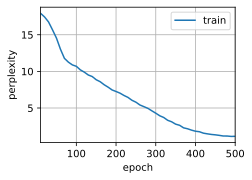

In [ ]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_lstm_params,
                            init_lstm_state, lstm)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

## Triển khai ngắn gọn với Torch

Sử dụng high-level APIs, chúng ta có thể khởi tạo trực tiếp mô hình LSTM.


perplexity 1.3, 10879.5 tokens/sec on /GPU:0


time traveller for so it will be convenient to speak of himwas e


traveller wo chat s bled le mentravely che ot i kralled the


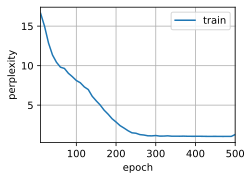

In [ ]:
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens)
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

## Tổng kết

* LSTM có 3 cổng: input gates, forget gates, and output gates để điều chỉnh luồng thông tin.
* Đầu ra hidden layer của LSTM gồm hidden state và memory cell. Và chỉ có hidden state được đưa qua output layer.
* LSTMs có thể hạn chế vấn đề vanishing and exploding gradients.


## Luyện tập

1. Điều chỉnh các hyperparameters và phân tích ảnh hưởng của chúng đến thời gian chạy, độ phức tạp và chuỗi đầu ra.
So sánh chi phí tính toán cho LSTM và RNN. Đặc biệt chú ý đến chi phí huấn luyện và suy luận.
